# Website Notebook

In [26]:
# Standard imports
# If any of these don't work, try doing `pip install _____`, or try looking up the error message.
import numpy as np
import pandas as pd
import json
import time
import os.path
from os import path
import math
import datetime
import unidecode
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Modules from sportsrefernece.ncaab for college basketball
from sportsreference.ncaab.boxscore import Boxscore as NCAAB_Boxscore
from sportsreference.ncaab.conferences import Conferences as NCAAB_Conferences
from sportsreference.ncaab.rankings import Rankings as NCAAB_Rankings
from sportsreference.ncaab.roster import Player as NCAAB_Player
from sportsreference.ncaab.roster import Roster as NCAAB_Roster
from sportsreference.ncaab.schedule import Schedule as NCAAB_Schedule
from sportsreference.ncaab.teams import Teams as NCAAB_Teams

# Modules from sportsrefernece.nba for NBA basketball
from sportsreference.nba.boxscore import Boxscore as NBA_Boxscore
from sportsreference.nba.roster import Player as NBA_Player
from sportsreference.nba.roster import Roster as NBA_Roster
from sportsreference.nba.schedule import Schedule as NBA_Schedule
from sportsreference.nba.teams import Teams as NBA_Teams

# Introduction

Hi everyone! In this notebook, we will be constructing a variety of different machine learning models to predict NBA rookie statlines from different college players input from the Anvil App!

Let's get started!

# A. College Data

**In order for us to pass up college stats for this player to be viewed in the front-end, we will need to:**
1. Clean the name
2. Find the college player stats for the input name
    - If they don't exist, tell the user that they don't, and provide the correct error message

### 1. Find college player stats for input name

In [28]:
# This method should hopefully reduce the number of failure cases.
def convert_nba_ncaa_name(name: str) -> str:
    """
    Converts the format of the NBA player_id to the NCAA player_id.

    You may want to elaborate on the logic on this function to reduce the number of failure cases later.
    """
    return unidecode.unidecode(name.lower().replace(" ", "-") + "-1")

### 2. Find the college player stats for the input name

In [29]:
def get_college_stats(player_name: str) -> dict:
    """
    Return a dictionary with the following keys:
    
    success: If the player was correctly found (boolean)
    data: Player data (pd.Dataframe)
    error: Error message, if success is false (string)
    """
    response = {}
    
    # This check if for players with hyphens in their name
#     if '-' in player_name:
#         response['success'] = False
#         response['data'] = None
#         response['error'] = 'This player has a hyphen in his name, and unfortunately, we cannot handle this type of data. Please re-try with a player without a hyphen in their name!'
#         return response

    clean_name = convert_nba_ncaa_name(player_name)
    
    # Checking if player does exist with current name
    try:
        player_data = NCAAB_Player(clean_name).dataframe
    except TypeError:
        response['success'] = False
        response['data'] = None
        response['error'] = "This player doesn't exist (or its name is not in the correct format). Please try a different player name."
        return response

    player_data.rename(columns=lambda x: 'NCAAB_' + x, inplace=True)
    last_year = player_data.iloc[[player_data.shape[0] - 2]]
    last_year.set_index(pd.Index(data=[player_name], name='Name'), inplace=True)
    
    response['success'] = True
    response['data'] = last_year # Change for Matt's formatting
    response['error'] = None
    return response

In [30]:
ayton = get_college_stats('Deandre Ayton')

In [31]:
ayton['data']

,NCAAB_assist_percentage,NCAAB_assists,NCAAB_block_percentage,NCAAB_blocks,NCAAB_box_plus_minus,NCAAB_conference,NCAAB_defensive_box_plus_minus,NCAAB_defensive_rebound_percentage,NCAAB_defensive_rebounds,NCAAB_defensive_win_shares,...,NCAAB_true_shooting_percentage,NCAAB_turnover_percentage,NCAAB_turnovers,NCAAB_two_point_attempts,NCAAB_two_point_percentage,NCAAB_two_pointers,NCAAB_usage_percentage,NCAAB_weight,NCAAB_win_shares,NCAAB_win_shares_per_40_minutes
Name,,,,,,,,,,,,,,,,,,,,,
Deandre Ayton,10.2,57,6.1,66,10.9,pac-12,4.0,28.2,287,2.1,...,0.65,11.3,69,416,0.635,264,26.6,250,7.6,0.259


In [32]:
# Pip install the library if you don't currently have it
!pip install anvil-uplink

### Making front-end endpoint for retrieving college data

# TODO: Make per game for the last year

In [33]:
import anvil.server
anvil.server.connect("CNBA5WRJQTXDQKUGWRYB75LH-FPEOE7AG4M72SKKS")

@anvil.server.callable
def get_college(name):
    """
    Making the front-end to back-end connection, and passing up college data.
    """
    response = get_college_stats(name)
    if not response['success']:
        return response
    
    column_names = ['NCAAB_' + name for name in ['points', 'total_rebounds', 'assists', 'steals', 'blocks']]
    
    def rename_cols(name):
        """
        Rename columns
        """
        new_names = {
            'NCAAB_points': 'pts',
            'NCAAB_total_rebounds': 'reb',
            'NCAAB_assists': 'ast',
            'NCAAB_steals': 'stl',
            'NCAAB_blocks': 'blk',
        }
        if name == 'Name':
            return name
        return new_names[name]
    
    response['data'] = [response['data'][column_names].reset_index().iloc[0].rename(lambda x: rename_cols(x)).to_dict()]
    return response

In [34]:
get_college('Karl-Anthony Towns')

{'success': True,
 'data': [{'Name': 'Karl-Anthony Towns',
   'pts': 401,
   'reb': 261,
   'ast': 44,
   'stl': 18,
   'blk': 88}],
 'error': None}

# B. Clean/Process Data

In [35]:
# Splitting data
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/player_data_final.csv')
NBA_col = ['NBA_points', 'NBA_total_rebounds', 'NBA_assists', 'NBA_steals', 'NBA_blocks']
train, test = data.drop(columns=NBA_col), data[NBA_col].set_index(pd.Index(data=data['name'], name='name'))
train.set_index('name', inplace=True)

**In order for us to make predictions from the college data to be rendering in the front-end, we first need to:**
1. Drop unneeded columns
2. Clean the data the same way we did in our initial data

### 1. Drop unneeded columns

In [36]:
def drop_columns(data: pd.DataFrame) -> pd.DataFrame:
    """
    Drops the columns from the input college data.
    """
    def drop_for_nans(data):
        # Drops columns due to NaNs inside the data.
        drop_col = [
            'NCAAB_box_plus_minus',
            'NCAAB_defensive_box_plus_minus',
            'NCAAB_offensive_box_plus_minus',
            'NCAAB_player_efficiency_rating',
            'NCAAB_three_point_percentage',
        ]
        return data.drop(columns=drop_col)
    
    def drop_for_qual(data):
        # Drops columns due to qualitative data
        qual_drop = [
            'NCAAB_conference', 
            'NCAAB_player_id',
            'NCAAB_team_abbreviation',
        ]
        return data.drop(columns=qual_drop)
    
    return drop_for_nans(drop_for_qual(data))

In [37]:
new_curry = drop_columns(curry['data'])

In [38]:
check_null(new_curry)

['NCAAB_defensive_rebound_percentage',
 'NCAAB_offensive_rebound_percentage',
 'NCAAB_points_produced',
 'NCAAB_steal_percentage']

### 2. Clean the data the same way we did initially

In [39]:
def clean_qualitative(data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the qualitative columns (height, position)
    """

    def convert_height(height: str) -> int:
        """
        Convert height from string to int (6-11 -> 83)
        """
        feet, inches = height.split("-")
        return int(feet) * 12 + int(inches)

    def clean_position(position: str) -> str:
        """
        If the player has a hypened position, remove the second one.
        """
        return position.split('-')[0]
    
    def one_hot_position(player):
        """
        Applies one hot encoding to the player's position.
        """
        positions = positions = ['Center', 'Forward', 'Guard']
        player[positions] = pd.DataFrame([
            [int(p == player['NCAAB_position']) for p in positions]
        ], index=player.index)
        return player
    
    data['NCAAB_height'] = data['NCAAB_height'].apply(convert_height)
    data['NCAAB_position'] = data['NCAAB_position'].apply(clean_position)
    return one_hot_position(data)

In [40]:
clean_curry = clean_qualitative(new_curry)

In [41]:
check_null(clean_curry)

['NCAAB_defensive_rebound_percentage',
 'NCAAB_offensive_rebound_percentage',
 'NCAAB_points_produced',
 'NCAAB_steal_percentage']

In [42]:
def feature_extraction(data: pd.DataFrame) -> pd.DataFrame:
    """
    Takes the columns we've qualitative selected from the dataset to be our features for our model.
    """
    columns_to_keep = [
        'NCAAB_assists',
        'NCAAB_blocks',
        'NCAAB_field_goal_attempts',
        'NCAAB_field_goal_percentage',
        'NCAAB_field_goals',
        'NCAAB_free_throw_attempt_rate',
        'NCAAB_free_throw_attempts',
        'NCAAB_free_throw_percentage',
        'NCAAB_free_throws',
        'NCAAB_games_played',
        'NCAAB_games_started',
        'NCAAB_height',
        'NCAAB_personal_fouls',
        'NCAAB_points',
        'NCAAB_steal_percentage',
        'NCAAB_steals',
        'NCAAB_three_point_attempt_rate',
        'NCAAB_three_point_attempts',
        'NCAAB_total_rebound_percentage',
        'NCAAB_total_rebounds',
        'NCAAB_turnover_percentage',
        'NCAAB_turnovers',
        'NCAAB_two_point_attempts',
        'NCAAB_two_point_percentage',
        'NCAAB_win_shares',
        'Guard',
        'Forward',
        'Center',
    ]
    return data[columns_to_keep]

In [43]:
final_curry = feature_extraction(clean_curry)

In [44]:
check_null(final_curry)

['NCAAB_steal_percentage']

In [45]:
def extra_cleaning(player_data, train=False):
    """
    Cleans the player's data further if there's any NaN values (older players).
    """
    def check_null(df):
        """
        Returns all columns that have a null value in the player's data
        """
        return df.columns[df.isna().any()].tolist()
    
    columns = check_null(player_data)
    if columns:
        for column in columns:
            # Replace value with the average of our training set
            player_data.loc[:, column] = train.mean()[column]
    return player_data

In [46]:
def format_data(player_data, train):
    """
    Returns the processed data in correct format for inputting into our models.
    """
    cols_dropped = drop_columns(player_data)
    clean_data = clean_qualitative(cols_dropped)
    featured_data = feature_extraction(clean_data)
    final_data = extra_cleaning(featured_data, train)
    return final_data

In [47]:
format_data(curry['data'], train)

,NCAAB_assists,NCAAB_blocks,NCAAB_field_goal_attempts,NCAAB_field_goal_percentage,NCAAB_field_goals,NCAAB_free_throw_attempt_rate,NCAAB_free_throw_attempts,NCAAB_free_throw_percentage,NCAAB_free_throws,NCAAB_games_played,...,NCAAB_total_rebound_percentage,NCAAB_total_rebounds,NCAAB_turnover_percentage,NCAAB_turnovers,NCAAB_two_point_attempts,NCAAB_two_point_percentage,NCAAB_win_shares,Guard,Forward,Center
Name,,,,,,,,,,,,,,,,,,,,,
Stephen Curry,189,8,687,0.454,312,0.365,251,0.876,220,34,...,6.9,151,13.5,126,351,0.519,9.9,1,0,0


# C. Make Models

**In order for us to make our predictions, we first take a look at all the different models we've made for the project.**

1. LinearRegression
2. K-Means
3. DecisionTrees
4. Neural Networks

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2)

In [49]:
# Re-shuffle data
def shuffle(train, test):
    """
    Shuffe the data around for re-trying results.
    """
    X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [50]:
# Loss function
def RMSE(y, y_pred):
    """
    Calculates the root mean squared error of the model's predictions.
    """
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [51]:
# Total loss function
def all_RMSE(y, y_pred):
    """
    Calculates the RMSE by each of the different stats, and the total RMSE
    """
    rmses = {}
    for num, name in enumerate(y_pred.columns):
        rmses[name] = RMSE(y[:, num], y_pred[name])
    rmses['Total RMSE'] = sum(rmses.values())
    return pd.Series(rmses)

In [52]:
# Standardize our data
def standardize(train, test):
    """
    Standardize both train and test based off of train's means and std's.
    """
    means, stds = train.mean(), train.std()
    norm_train = (train - means) / stds
    norm_test = (test - means) / stds
    return norm_train, norm_test, means, stds

### 1A. Linear Regression (without standardization)

In [53]:
X_train, X_test, y_train, y_test = shuffle(train, test)

In [54]:
# Create model
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
# Make predictions
y_pred = linear_model.predict(X_test)

In [56]:
# RMSE for points
RMSE(y_test.values[:, 0], y_pred[:, 0])

287.20042374056897

In [57]:
# Total RMSE
all_RMSE(y_pred, y_test)

NBA_points            287.200424
NBA_total_rebounds    133.098414
NBA_assists            66.658962
NBA_steals             21.998478
NBA_blocks             16.498724
Total RMSE            525.455002
dtype: float64

### 1B. Linear Regression (with standardization)

In [58]:
X_train, X_test, y_train, y_test = shuffle(train, test)

In [59]:
# Standardize data
norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

In [60]:
# Create model
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(norm_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
# Make predictions
y_pred = linear_model.predict(norm_X_test)

In [62]:
# RMSE for points
RMSE(y_test.values[:, 0], y_pred[:, 0])

297.4820297193011

In [63]:
# Total RMSE
all_RMSE(y_pred, y_test)

NBA_points            297.482030
NBA_total_rebounds    124.932902
NBA_assists            88.721409
NBA_steals             24.783474
NBA_blocks             18.423635
Total RMSE            554.343451
dtype: float64

### 2. K-Means

In [64]:
# Shuffle the data up
X_train, X_test, y_train, y_test = shuffle(train, test)

In [65]:
# Standardize data
norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

In [66]:
# Fit model and produce labels
from sklearn.cluster import KMeans
k_means_cluster = KMeans(n_clusters=120, max_iter=10000, n_init=100).fit(norm_X_train.values)
X_copy = norm_X_train.copy(deep=True)
X_copy['label'] = k_means_cluster.labels_

In [67]:
# Find the predicted labels of the test set
label_pred = k_means_cluster.predict(norm_X_test)

In [68]:
def find_predictions(labels, X_copy, y_train):
    """
    Finds the predictions for these different players
    """
    all_preds = []
    for label in label_pred:
        similar_players = X_copy[X_copy['label'] == label].index
        similar_avg_stats = y_train.loc[similar_players].mean()
        all_preds.append(similar_avg_stats.values)
    return np.array(all_preds)

In [69]:
# Find stat predictions for the test set
y_pred = find_predictions(label_pred, X_copy, y_train)

In [70]:
# RMSE for points
RMSE(y_test.values[:, 0], y_pred[:, 0])

306.16999948416844

In [71]:
# Total RMSE
all_RMSE(y_pred, y_test)

NBA_points            306.169999
NBA_total_rebounds    123.519383
NBA_assists            80.659485
NBA_steals             24.040265
NBA_blocks             19.748277
Total RMSE            554.137411
dtype: float64

### 2B. Run K-Means multiple times for long-term RMSEs

In [72]:
def run_x_times(x):
    """
    Runs K-Means 'x' number of times to average the RMSEs.
    """
    total_avg = []
    for _ in range(10):
        # Shuffle the data up
        X_train, X_test, y_train, y_test = shuffle(train, test)

        # Standardize data
        norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

        # Fit model and produce labels
        from sklearn.cluster import KMeans
        k_means_cluster = KMeans(n_clusters=120, max_iter=10000, n_init=100).fit(norm_X_train.values)
        X_copy = norm_X_train.copy(deep=True)
        X_copy['label'] = k_means_cluster.labels_

        # Find the predicted labels of the test set
        label_pred = k_means_cluster.predict(norm_X_test)

        def find_predictions(labels, X_copy, y_train):
            """
            Finds the predictions for these different players
            """
            all_preds = []
            for label in label_pred:
                similar_players = X_copy[X_copy['label'] == label].index
                similar_avg_stats = y_train.loc[similar_players].mean()
                all_preds.append(similar_avg_stats.values)
            return np.array(all_preds)

        # Find stat predictions for the test set
        y_pred = find_predictions(label_pred, X_copy, y_train)
        total_avg.append(all_RMSE(y_pred, y_test).values)
        
    return np.array(total_avg)

In [73]:
avgs = run_x_times(10)

In [74]:
for i in range(5):
    print(np.mean(avgs[:, i]))

312.7461213782737
135.34965879354854
89.00250814669964
28.39555444383846
20.27429458959154


### 3. Decision Trees

In [75]:
# Shuffle data
X_train, X_test, y_train, y_test = shuffle(train, test)

In [76]:
# Standardize data
norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

In [77]:
# Create model
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor(min_samples_split=5, max_depth=15)
DTR.fit(norm_X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [78]:
# Training RMSE
all_RMSE(DTR.predict(norm_X_train), y_train)

NBA_points            135.872460
NBA_total_rebounds     70.824972
NBA_assists            43.403987
NBA_steals             13.441761
NBA_blocks             11.369170
Total RMSE            274.912350
dtype: float64

In [79]:
# Test total RMSE
all_RMSE(DTR.predict(norm_X_test), y_test)

NBA_points            423.490444
NBA_total_rebounds    161.566020
NBA_assists           107.936959
NBA_steals             30.152443
NBA_blocks             20.916563
Total RMSE            744.062428
dtype: float64

### 3.1 Trying variety of different Decision Trees

In [80]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

In [81]:
DT_errors = []
ET_errors = []
RF_errors = []

def fit_predict_error(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return RMSE(model.predict(X_test), y_test)

for i in range(1, 25):
    DTR = DecisionTreeRegressor(max_depth=i)
    error = fit_predict_error(DTR, norm_X_train, y_train, norm_X_test, y_test)
    DT_errors.append(error.values)
    
    ETR = ExtraTreesRegressor(max_depth=i)
    error = fit_predict_error(ETR, norm_X_train, y_train, norm_X_test, y_test)
    ET_errors.append(error.values)
    
    RFR = RandomForestRegressor(max_depth=i)
    error = fit_predict_error(RFR, norm_X_train, y_train, norm_X_test, y_test)
    RF_errors.append(error.values)

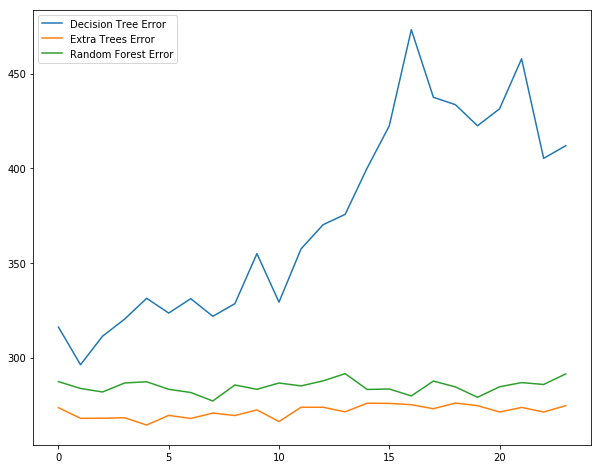

In [82]:
import matplotlib.pyplot as plt

# Plotting RMSE's for points
plt.figure(figsize=(10, 8))
plt.plot(np.array(DT_errors)[:, 0], label='Decision Tree Error')
plt.plot(np.array(ET_errors)[:, 0], label='Extra Trees Error')
plt.plot(np.array(RF_errors)[:, 0], label='Random Forest Error')
plt.legend()
plt.show();

### 4. Neural Networks

In [83]:
# Shuffle the data up
X_train, X_test, y_train, y_test = shuffle(train, test)

In [84]:
# Standardize data
norm_X_train, norm_X_test, x_means, x_stds = standardize(X_train, X_test)

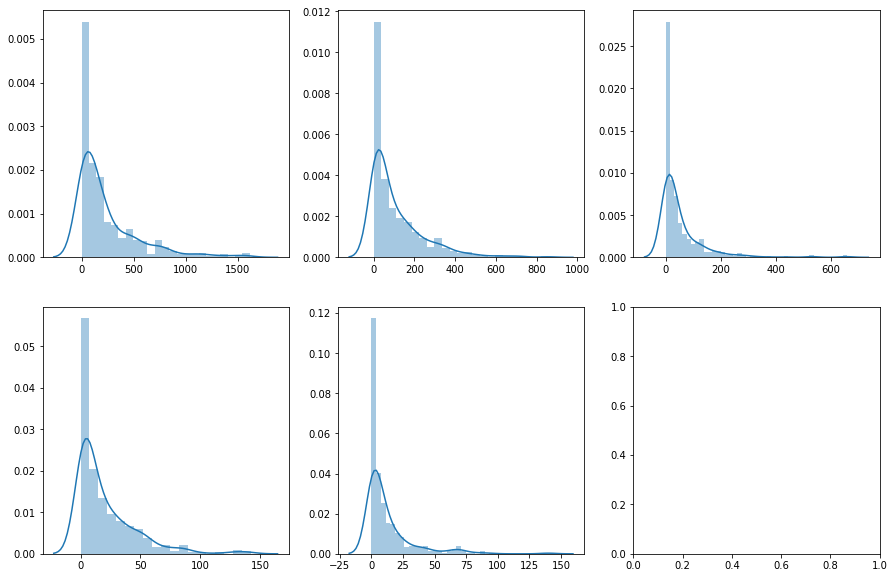

In [85]:
# Y-value skewness
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for col_num in range(len(y_train.columns)):
    sns.distplot(y_train.iloc[:, col_num].to_frame(), ax=axes[col_num // 3][col_num % 3]);

In [86]:
### STANDARDIZE Y-VALUES (this is because y_values are so skewed)
norm_y_train, _, y_means, y_stds = standardize(y_train, y_test)

In [87]:
# Import libraries for model
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [88]:
def make_nn_arch():
    """
    Make basic neural network architecture for our dataset.
    """
    model = Sequential()
    model.add(Dense(35, activation='tanh', input_shape=(28,)))
    model.add(Dense(15, activation='tanh', input_shape=(35,)))
    model.add(Dense(1, activation='tanh', input_shape=(15,)))
    # For a mean squared error regression problem
    model.compile(
        optimizer=keras.optimizers.SGD(
            lr=0.001,
            momentum=0.9,
            nesterov=True
        ), #How to Learn
        loss='mse', # What to Learn
    )
    return model

In [89]:
# Create and fit Neural Network
model = make_nn_arch()
model.fit(
    x=norm_X_train,
    y=norm_y_train['NBA_points'], 
    epochs=100,
)

Epoch 1/100
420/420 [==============================] - 0s 392us/step - loss: 1.0571
Epoch 2/100
420/420 [==============================] - 0s 36us/step - loss: 0.9579
Epoch 3/100
420/420 [==============================] - 0s 43us/step - loss: 0.9211
Epoch 4/100
420/420 [==============================] - 0s 39us/step - loss: 0.9089
Epoch 5/100
420/420 [==============================] - 0s 42us/step - loss: 0.9008
Epoch 6/100
420/420 [==============================] - 0s 44us/step - loss: 0.8895
Epoch 7/100
420/420 [==============================] - 0s 37us/step - loss: 0.8814
Epoch 8/100
420/420 [==============================] - 0s 32us/step - loss: 0.8741
Epoch 9/100
420/420 [==============================] - 0s 36us/step - loss: 0.8716
Epoch 10/100
420/420 [==============================] - 0s 46us/step - loss: 0.8633
Epoch 11/100
420/420 [==============================] - 0s 34us/step - loss: 0.8595
Epoch 12/100
420/420 [==============================] - 0s 39us/step - loss: 0.8605


420/420 [==============================] - 0s 45us/step - loss: 0.6824
Epoch 99/100
420/420 [==============================] - 0s 48us/step - loss: 0.6787
Epoch 100/100
420/420 [==============================] - 0s 38us/step - loss: 0.6797


In [90]:
# Loss function
def RMSE(y, y_pred):
    """
    Calculates the root mean squared error of the model's predictions.
    """
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [91]:
# Make predictions
y_pred = model.predict(norm_X_test)

In [92]:
# RMSE for points
RMSE(((y_pred * y_stds['NBA_points']) + y_means['NBA_points']).flatten(), y_test['NBA_points'])

250.6495441446534

### 4.1 Make Neural Networks for all stats

In [93]:
def train_all_and_predict():
    
    rmses = []
    
    for column in y_train.columns:

        # Create and fit Neural Network
        model = make_nn_arch()
        model.fit(
            x=norm_X_train,
            y=norm_y_train[column], 
            epochs=100,
        )
        y_pred = model.predict(norm_X_test)

        # RMSE by stat category
        rmse = RMSE(((y_pred * y_stds[column]) + y_means[column]).flatten(), y_test[column])
        rmses.append(rmse)
    
    return rmses

In [94]:
rmses = train_all_and_predict()

Epoch 1/100
420/420 [==============================] - 0s 171us/step - loss: 1.0778
Epoch 2/100
420/420 [==============================] - 0s 42us/step - loss: 0.9383
Epoch 3/100
420/420 [==============================] - 0s 42us/step - loss: 0.9042
Epoch 4/100
420/420 [==============================] - 0s 42us/step - loss: 0.8876
Epoch 5/100
420/420 [==============================] - 0s 41us/step - loss: 0.8839
Epoch 6/100
420/420 [==============================] - 0s 49us/step - loss: 0.8777
Epoch 7/100
420/420 [==============================] - 0s 37us/step - loss: 0.8762
Epoch 8/100
420/420 [==============================] - 0s 44us/step - loss: 0.8698
Epoch 9/100
420/420 [==============================] - 0s 36us/step - loss: 0.8672
Epoch 10/100
420/420 [==============================] - 0s 35us/step - loss: 0.8658
Epoch 11/100
420/420 [==============================] - 0s 45us/step - loss: 0.8546
Epoch 12/100
420/420 [==============================] - 0s 37us/step - loss: 0.8496


420/420 [==============================] - 0s 40us/step - loss: 0.6718
Epoch 99/100
420/420 [==============================] - 0s 40us/step - loss: 0.6658
Epoch 100/100
420/420 [==============================] - 0s 43us/step - loss: 0.6608
Epoch 1/100
420/420 [==============================] - 0s 168us/step - loss: 0.9751
Epoch 2/100
420/420 [==============================] - 0s 42us/step - loss: 0.8879
Epoch 3/100
420/420 [==============================] - 0s 39us/step - loss: 0.8508
Epoch 4/100
420/420 [==============================] - 0s 38us/step - loss: 0.8412
Epoch 5/100
420/420 [==============================] - 0s 38us/step - loss: 0.8322
Epoch 6/100
420/420 [==============================] - 0s 39us/step - loss: 0.8275
Epoch 7/100
420/420 [==============================] - 0s 38us/step - loss: 0.8242
Epoch 8/100
420/420 [==============================] - 0s 37us/step - loss: 0.8187
Epoch 9/100
420/420 [==============================] - 0s 42us/step - loss: 0.8164
Epoch 10/100

420/420 [==============================] - 0s 33us/step - loss: 0.6555
Epoch 96/100
420/420 [==============================] - 0s 34us/step - loss: 0.6520
Epoch 97/100
420/420 [==============================] - 0s 34us/step - loss: 0.6485
Epoch 98/100
420/420 [==============================] - 0s 37us/step - loss: 0.6455
Epoch 99/100
420/420 [==============================] - 0s 34us/step - loss: 0.6421
Epoch 100/100
420/420 [==============================] - 0s 36us/step - loss: 0.6426
Epoch 1/100
420/420 [==============================] - 0s 167us/step - loss: 1.0102
Epoch 2/100
420/420 [==============================] - 0s 38us/step - loss: 0.9475
Epoch 3/100
420/420 [==============================] - 0s 36us/step - loss: 0.9018
Epoch 4/100
420/420 [==============================] - 0s 40us/step - loss: 0.8697
Epoch 5/100
420/420 [==============================] - 0s 39us/step - loss: 0.8446
Epoch 6/100
420/420 [==============================] - 0s 43us/step - loss: 0.8306
Epoch 7/1

420/420 [==============================] - 0s 31us/step - loss: 0.6588
Epoch 93/100
420/420 [==============================] - 0s 38us/step - loss: 0.6582
Epoch 94/100
420/420 [==============================] - 0s 41us/step - loss: 0.6577
Epoch 95/100
420/420 [==============================] - 0s 34us/step - loss: 0.6575
Epoch 96/100
420/420 [==============================] - 0s 36us/step - loss: 0.6559
Epoch 97/100
420/420 [==============================] - 0s 37us/step - loss: 0.6567
Epoch 98/100
420/420 [==============================] - 0s 37us/step - loss: 0.6547
Epoch 99/100
420/420 [==============================] - 0s 34us/step - loss: 0.6552
Epoch 100/100
420/420 [==============================] - 0s 35us/step - loss: 0.6540
Epoch 1/100
420/420 [==============================] - 0s 185us/step - loss: 1.1054
Epoch 2/100
420/420 [==============================] - 0s 40us/step - loss: 0.9928
Epoch 3/100
420/420 [==============================] - 0s 40us/step - loss: 0.9421
Epoch 

420/420 [==============================] - 0s 37us/step - loss: 0.6620
Epoch 90/100
420/420 [==============================] - 0s 30us/step - loss: 0.6594
Epoch 91/100
420/420 [==============================] - 0s 42us/step - loss: 0.6587
Epoch 92/100
420/420 [==============================] - 0s 37us/step - loss: 0.6565
Epoch 93/100
420/420 [==============================] - 0s 48us/step - loss: 0.6548
Epoch 94/100
420/420 [==============================] - 0s 44us/step - loss: 0.6548
Epoch 95/100
420/420 [==============================] - 0s 38us/step - loss: 0.6519
Epoch 96/100
420/420 [==============================] - 0s 38us/step - loss: 0.6494
Epoch 97/100
420/420 [==============================] - 0s 40us/step - loss: 0.6452
Epoch 98/100
420/420 [==============================] - 0s 39us/step - loss: 0.6461
Epoch 99/100
420/420 [==============================] - 0s 41us/step - loss: 0.6435
Epoch 100/100
420/420 [==============================] - 0s 41us/step - loss: 0.6406
Epoc

420/420 [==============================] - 0s 34us/step - loss: 0.6798
Epoch 87/100
420/420 [==============================] - 0s 37us/step - loss: 0.6774
Epoch 88/100
420/420 [==============================] - 0s 34us/step - loss: 0.6767
Epoch 89/100
420/420 [==============================] - 0s 35us/step - loss: 0.6753
Epoch 90/100
420/420 [==============================] - 0s 38us/step - loss: 0.6770
Epoch 91/100
420/420 [==============================] - 0s 36us/step - loss: 0.6742
Epoch 92/100
420/420 [==============================] - 0s 36us/step - loss: 0.6733
Epoch 93/100
420/420 [==============================] - 0s 32us/step - loss: 0.6698
Epoch 94/100
420/420 [==============================] - 0s 30us/step - loss: 0.6687
Epoch 95/100
420/420 [==============================] - 0s 32us/step - loss: 0.6673
Epoch 96/100
420/420 [==============================] - 0s 32us/step - loss: 0.6671
Epoch 97/100
420/420 [==============================] - 0s 35us/step - loss: 0.6665
Epoch

In [95]:
rmses

[247.194014766523,
 101.11984623574807,
 78.95225897267302,
 24.5994431129239,
 15.43922729979202]

### 4. Neural Networks

In [96]:
# Shuffle the data up
X_train, X_test, y_train, y_test = shuffle(train, test)

In [97]:
# Standardize data
norm_X_train, norm_X_test, x_means, x_stds = standardize(X_train, X_test)

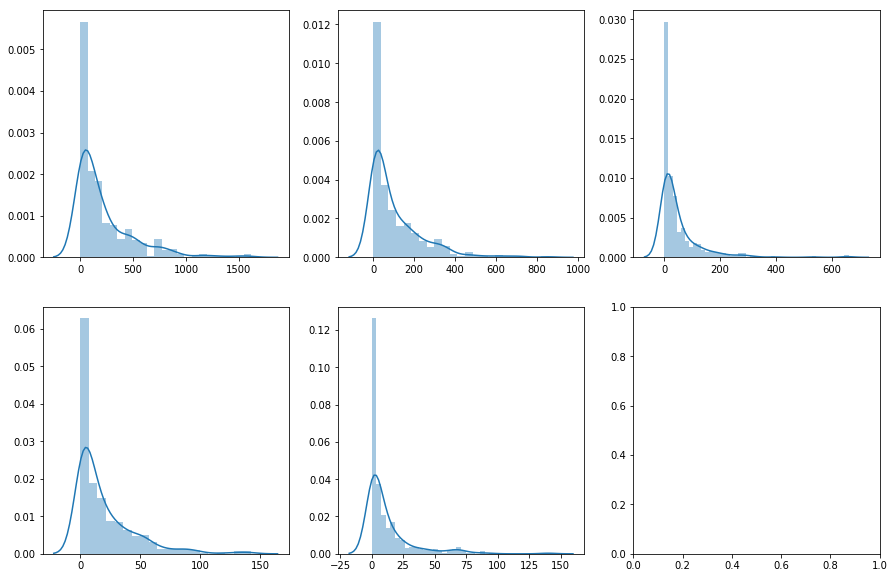

In [98]:
# Y-value skewness
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for col_num in range(len(y_train.columns)):
    sns.distplot(y_train.iloc[:, col_num].to_frame(), ax=axes[col_num // 3][col_num % 3]);

In [99]:
### STANDARDIZE Y-VALUES (this is because y_values are so skewed)
norm_y_train, _, y_means, y_stds = standardize(y_train, y_test)

In [100]:
# Import libraries for model
import keras
from keras.models import Sequential
from keras.layers import Dense

In [101]:
def make_nn_arch():
    """
    Make basic neural network architecture for our dataset.
    """
    model = Sequential()
    model.add(Dense(20, activation='tanh', input_shape=(28,)))
    model.add(Dense(35, activation='tanh', input_shape=(35,)))
    model.add(Dense(15, activation='tanh', input_shape=(35,)))
    model.add(Dense(1, activation='tanh', input_shape=(15,)))

    # For a mean squared error regression problem
    model.compile(
        optimizer=keras.optimizers.SGD(
            lr=0.001,
            momentum=0.9,
            nesterov=True
        ), #How to Learn
        loss='mse', # What to Learn
    )
    return model

In [102]:
# Create and fit Neural Network
model = make_nn_arch()
model.fit(
    x=norm_X_train,
    y=norm_y_train['NBA_points'], 
    epochs=100,
)

Epoch 1/100
420/420 [==============================] - 0s 207us/step - loss: 1.0765
Epoch 2/100
420/420 [==============================] - 0s 36us/step - loss: 0.9274
Epoch 3/100
420/420 [==============================] - 0s 45us/step - loss: 0.8929
Epoch 4/100
420/420 [==============================] - 0s 38us/step - loss: 0.8801
Epoch 5/100
420/420 [==============================] - 0s 40us/step - loss: 0.8705
Epoch 6/100
420/420 [==============================] - 0s 39us/step - loss: 0.8624
Epoch 7/100
420/420 [==============================] - 0s 52us/step - loss: 0.8589
Epoch 8/100
420/420 [==============================] - 0s 34us/step - loss: 0.8488
Epoch 9/100
420/420 [==============================] - 0s 44us/step - loss: 0.8449
Epoch 10/100
420/420 [==============================] - 0s 37us/step - loss: 0.8573
Epoch 11/100
420/420 [==============================] - 0s 36us/step - loss: 0.8484
Epoch 12/100
420/420 [==============================] - 0s 42us/step - loss: 0.8340


420/420 [==============================] - 0s 36us/step - loss: 0.6071
Epoch 99/100
420/420 [==============================] - 0s 34us/step - loss: 0.6113
Epoch 100/100
420/420 [==============================] - 0s 34us/step - loss: 0.5999


In [103]:
# Loss function
def RMSE(y, y_pred):
    """
    Calculates the root mean squared error of the model's predictions.
    """
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [104]:
# Make predictions
y_pred = model.predict(norm_X_test)

In [105]:
# RMSE for points
RMSE(((y_pred * y_stds['NBA_points']) + y_means['NBA_points']).flatten(), y_test['NBA_points'])

332.50551590541266

### 4.1 Make Neural Networks for all stats

In [106]:
def train_all_and_predict():
    
    rmses = []
    
    for column in y_train.columns:

        # Create and fit Neural Network
        model = make_nn_arch()
        model.fit(
            x=norm_X_train,
            y=norm_y_train[column], 
            epochs=100,
        )
        y_pred = model.predict(norm_X_test)

        # RMSE by stat category
        rmse = RMSE(((y_pred * y_stds[column]) + y_means[column]).flatten(), y_test[column])
        rmses.append(rmse)
    
    return rmses

In [107]:
rmses = train_all_and_predict()

Epoch 1/100
420/420 [==============================] - 0s 223us/step - loss: 0.9799
Epoch 2/100
420/420 [==============================] - 0s 39us/step - loss: 0.9296
Epoch 3/100
420/420 [==============================] - 0s 42us/step - loss: 0.9111
Epoch 4/100
420/420 [==============================] - 0s 45us/step - loss: 0.9000
Epoch 5/100
420/420 [==============================] - 0s 47us/step - loss: 0.8925
Epoch 6/100
420/420 [==============================] - 0s 43us/step - loss: 0.8904
Epoch 7/100
420/420 [==============================] - 0s 39us/step - loss: 0.8847
Epoch 8/100
420/420 [==============================] - 0s 41us/step - loss: 0.8745
Epoch 9/100
420/420 [==============================] - 0s 40us/step - loss: 0.8727
Epoch 10/100
420/420 [==============================] - 0s 37us/step - loss: 0.8663
Epoch 11/100
420/420 [==============================] - 0s 39us/step - loss: 0.8617
Epoch 12/100
420/420 [==============================] - 0s 36us/step - loss: 0.8596


420/420 [==============================] - 0s 35us/step - loss: 0.6734
Epoch 99/100
420/420 [==============================] - 0s 40us/step - loss: 0.6739
Epoch 100/100
420/420 [==============================] - 0s 34us/step - loss: 0.6774
Epoch 1/100
420/420 [==============================] - 0s 222us/step - loss: 0.9962
Epoch 2/100
420/420 [==============================] - 0s 42us/step - loss: 0.9188
Epoch 3/100
420/420 [==============================] - 0s 44us/step - loss: 0.8899
Epoch 4/100
420/420 [==============================] - 0s 42us/step - loss: 0.8758
Epoch 5/100
420/420 [==============================] - 0s 42us/step - loss: 0.8686
Epoch 6/100
420/420 [==============================] - 0s 41us/step - loss: 0.8613
Epoch 7/100
420/420 [==============================] - 0s 42us/step - loss: 0.8564
Epoch 8/100
420/420 [==============================] - 0s 42us/step - loss: 0.8538
Epoch 9/100
420/420 [==============================] - 0s 40us/step - loss: 0.8501
Epoch 10/100

420/420 [==============================] - 0s 38us/step - loss: 0.7450
Epoch 96/100
420/420 [==============================] - 0s 37us/step - loss: 0.7432
Epoch 97/100
420/420 [==============================] - 0s 39us/step - loss: 0.7419
Epoch 98/100
420/420 [==============================] - 0s 34us/step - loss: 0.7433
Epoch 99/100
420/420 [==============================] - 0s 38us/step - loss: 0.7411
Epoch 100/100
420/420 [==============================] - 0s 42us/step - loss: 0.7395
Epoch 1/100
420/420 [==============================] - 0s 207us/step - loss: 1.1142
Epoch 2/100
420/420 [==============================] - 0s 39us/step - loss: 0.8709
Epoch 3/100
420/420 [==============================] - 0s 38us/step - loss: 0.8267
Epoch 4/100
420/420 [==============================] - 0s 39us/step - loss: 0.8107
Epoch 5/100
420/420 [==============================] - 0s 37us/step - loss: 0.8047
Epoch 6/100
420/420 [==============================] - 0s 39us/step - loss: 0.7948
Epoch 7/1

420/420 [==============================] - 0s 34us/step - loss: 0.6751
Epoch 93/100
420/420 [==============================] - 0s 37us/step - loss: 0.6728
Epoch 94/100
420/420 [==============================] - 0s 35us/step - loss: 0.6747
Epoch 95/100
420/420 [==============================] - 0s 38us/step - loss: 0.6733
Epoch 96/100
420/420 [==============================] - 0s 34us/step - loss: 0.6722
Epoch 97/100
420/420 [==============================] - 0s 34us/step - loss: 0.6698
Epoch 98/100
420/420 [==============================] - 0s 38us/step - loss: 0.6713
Epoch 99/100
420/420 [==============================] - 0s 36us/step - loss: 0.6686
Epoch 100/100
420/420 [==============================] - 0s 34us/step - loss: 0.6682
Epoch 1/100
420/420 [==============================] - 0s 208us/step - loss: 1.0851
Epoch 2/100
420/420 [==============================] - 0s 35us/step - loss: 0.9517
Epoch 3/100
420/420 [==============================] - 0s 39us/step - loss: 0.9137
Epoch 

420/420 [==============================] - 0s 35us/step - loss: 0.6387
Epoch 90/100
420/420 [==============================] - 0s 34us/step - loss: 0.6389
Epoch 91/100
420/420 [==============================] - 0s 34us/step - loss: 0.6351
Epoch 92/100
420/420 [==============================] - 0s 35us/step - loss: 0.6359
Epoch 93/100
420/420 [==============================] - 0s 34us/step - loss: 0.6307
Epoch 94/100
420/420 [==============================] - 0s 34us/step - loss: 0.6290
Epoch 95/100
420/420 [==============================] - 0s 37us/step - loss: 0.6259
Epoch 96/100
420/420 [==============================] - 0s 36us/step - loss: 0.6245
Epoch 97/100
420/420 [==============================] - 0s 34us/step - loss: 0.6253
Epoch 98/100
420/420 [==============================] - 0s 33us/step - loss: 0.6233
Epoch 99/100
420/420 [==============================] - 0s 33us/step - loss: 0.6201
Epoch 100/100
420/420 [==============================] - 0s 35us/step - loss: 0.6172
Epoc

420/420 [==============================] - 0s 37us/step - loss: 0.6768
Epoch 87/100
420/420 [==============================] - 0s 39us/step - loss: 0.6781
Epoch 88/100
420/420 [==============================] - 0s 40us/step - loss: 0.6754
Epoch 89/100
420/420 [==============================] - 0s 38us/step - loss: 0.6720
Epoch 90/100
420/420 [==============================] - 0s 38us/step - loss: 0.6717
Epoch 91/100
420/420 [==============================] - 0s 36us/step - loss: 0.6710
Epoch 92/100
420/420 [==============================] - 0s 36us/step - loss: 0.6683
Epoch 93/100
420/420 [==============================] - 0s 37us/step - loss: 0.6706
Epoch 94/100
420/420 [==============================] - 0s 36us/step - loss: 0.6667
Epoch 95/100
420/420 [==============================] - 0s 38us/step - loss: 0.6663
Epoch 96/100
420/420 [==============================] - 0s 36us/step - loss: 0.6638
Epoch 97/100
420/420 [==============================] - 0s 39us/step - loss: 0.6644
Epoch

In [108]:
rmses

[336.5749208722412,
 121.24781297470078,
 92.53368252609626,
 24.082815191229713,
 14.926382675022614]

# D. Training the final models

In [109]:
####################
### FINAL MODELS ###
####################

In [110]:
# Standardize data
X_means, X_stds = train.mean(), train.std()
y_means, y_stds = test.mean(), test.std()
X_norm = (train - X_means) / X_stds
y_norm = (test - y_means) / y_stds

In [111]:
def train_all(X_train, y_train):
    """
    Trains all 5 Neural Networks we need for the 5 stat categories.
    """
    models = {}
    
    for column in y_train.columns:

        # Create and fit Neural Network
        model = make_nn_arch()
        model.fit(
            x=X_train,
            y=y_train[column], 
            epochs=100,
        )
        models[column] = model
        
    return models

In [112]:
nn_models = train_all(X_norm, y_norm)

Epoch 1/100
525/525 [==============================] - 0s 175us/step - loss: 1.1505
Epoch 2/100
525/525 [==============================] - 0s 39us/step - loss: 1.0482
Epoch 3/100
525/525 [==============================] - 0s 38us/step - loss: 1.0010
Epoch 4/100
525/525 [==============================] - 0s 43us/step - loss: 0.9795
Epoch 5/100
525/525 [==============================] - 0s 46us/step - loss: 0.9603
Epoch 6/100
525/525 [==============================] - 0s 38us/step - loss: 0.9477
Epoch 7/100
525/525 [==============================] - 0s 38us/step - loss: 0.9363
Epoch 8/100
525/525 [==============================] - 0s 35us/step - loss: 0.9280
Epoch 9/100
525/525 [==============================] - 0s 37us/step - loss: 0.9241
Epoch 10/100
525/525 [==============================] - 0s 37us/step - loss: 0.9170
Epoch 11/100
525/525 [==============================] - 0s 43us/step - loss: 0.9117
Epoch 12/100
525/525 [==============================] - 0s 33us/step - loss: 0.9053


525/525 [==============================] - 0s 36us/step - loss: 0.7043
Epoch 99/100
525/525 [==============================] - 0s 35us/step - loss: 0.7052
Epoch 100/100
525/525 [==============================] - 0s 32us/step - loss: 0.7012
Epoch 1/100
525/525 [==============================] - 0s 164us/step - loss: 1.0526
Epoch 2/100
525/525 [==============================] - 0s 35us/step - loss: 0.9432
Epoch 3/100
525/525 [==============================] - 0s 37us/step - loss: 0.9084
Epoch 4/100
525/525 [==============================] - 0s 35us/step - loss: 0.8914
Epoch 5/100
525/525 [==============================] - 0s 36us/step - loss: 0.8777
Epoch 6/100
525/525 [==============================] - 0s 33us/step - loss: 0.8676
Epoch 7/100
525/525 [==============================] - 0s 33us/step - loss: 0.8622
Epoch 8/100
525/525 [==============================] - 0s 38us/step - loss: 0.8563
Epoch 9/100
525/525 [==============================] - 0s 36us/step - loss: 0.8523
Epoch 10/100

525/525 [==============================] - 0s 34us/step - loss: 0.6697
Epoch 96/100
525/525 [==============================] - 0s 35us/step - loss: 0.6699
Epoch 97/100
525/525 [==============================] - 0s 36us/step - loss: 0.6668
Epoch 98/100
525/525 [==============================] - 0s 33us/step - loss: 0.6656
Epoch 99/100
525/525 [==============================] - 0s 34us/step - loss: 0.6623
Epoch 100/100
525/525 [==============================] - 0s 32us/step - loss: 0.6645
Epoch 1/100
525/525 [==============================] - 0s 169us/step - loss: 1.6106
Epoch 2/100
525/525 [==============================] - 0s 37us/step - loss: 1.1283
Epoch 3/100
525/525 [==============================] - 0s 35us/step - loss: 0.8906
Epoch 4/100
525/525 [==============================] - 0s 37us/step - loss: 0.8626
Epoch 5/100
525/525 [==============================] - 0s 36us/step - loss: 0.8491
Epoch 6/100
525/525 [==============================] - 0s 37us/step - loss: 0.8385
Epoch 7/1

525/525 [==============================] - 0s 34us/step - loss: 0.6968
Epoch 93/100
525/525 [==============================] - 0s 31us/step - loss: 0.6928
Epoch 94/100
525/525 [==============================] - 0s 32us/step - loss: 0.6923
Epoch 95/100
525/525 [==============================] - 0s 30us/step - loss: 0.6908
Epoch 96/100
525/525 [==============================] - 0s 31us/step - loss: 0.6902
Epoch 97/100
525/525 [==============================] - 0s 33us/step - loss: 0.6915
Epoch 98/100
525/525 [==============================] - 0s 35us/step - loss: 0.6888
Epoch 99/100
525/525 [==============================] - 0s 33us/step - loss: 0.6887
Epoch 100/100
525/525 [==============================] - 0s 33us/step - loss: 0.6879
Epoch 1/100
525/525 [==============================] - 0s 166us/step - loss: 1.2343
Epoch 2/100
525/525 [==============================] - 0s 37us/step - loss: 1.0189
Epoch 3/100
525/525 [==============================] - 0s 34us/step - loss: 0.9404
Epoch 

525/525 [==============================] - 0s 31us/step - loss: 0.6865
Epoch 90/100
525/525 [==============================] - 0s 34us/step - loss: 0.6848
Epoch 91/100
525/525 [==============================] - 0s 32us/step - loss: 0.6825
Epoch 92/100
525/525 [==============================] - 0s 33us/step - loss: 0.6799
Epoch 93/100
525/525 [==============================] - 0s 35us/step - loss: 0.6785
Epoch 94/100
525/525 [==============================] - 0s 38us/step - loss: 0.6772
Epoch 95/100
525/525 [==============================] - 0s 35us/step - loss: 0.6736
Epoch 96/100
525/525 [==============================] - 0s 35us/step - loss: 0.6723
Epoch 97/100
525/525 [==============================] - 0s 32us/step - loss: 0.6704
Epoch 98/100
525/525 [==============================] - 0s 47us/step - loss: 0.6698
Epoch 99/100
525/525 [==============================] - 0s 34us/step - loss: 0.6649
Epoch 100/100
525/525 [==============================] - 0s 32us/step - loss: 0.6691
Epoc

525/525 [==============================] - 0s 40us/step - loss: 0.6861
Epoch 87/100
525/525 [==============================] - 0s 55us/step - loss: 0.6880
Epoch 88/100
525/525 [==============================] - 0s 50us/step - loss: 0.6841
Epoch 89/100
525/525 [==============================] - 0s 58us/step - loss: 0.6825
Epoch 90/100
525/525 [==============================] - 0s 45us/step - loss: 0.6808
Epoch 91/100
525/525 [==============================] - 0s 41us/step - loss: 0.6809
Epoch 92/100
525/525 [==============================] - 0s 41us/step - loss: 0.6802
Epoch 93/100
525/525 [==============================] - 0s 42us/step - loss: 0.6788
Epoch 94/100
525/525 [==============================] - 0s 31us/step - loss: 0.6771
Epoch 95/100
525/525 [==============================] - 0s 45us/step - loss: 0.6753
Epoch 96/100
525/525 [==============================] - 0s 39us/step - loss: 0.6744
Epoch 97/100
525/525 [==============================] - 0s 39us/step - loss: 0.6735
Epoch

In [113]:
@anvil.server.callable
def get_predicts(name):
    """
    Return a one-item list with the dictionary in it.
    If doesn't exist, return empty list
    """
    
    def rename_cols(name):
        """
        Rename columns
        """
        new_names = {
            'NBA_points': 'pts',
            'NBA_total_rebounds': 'reb',
            'NBA_assists': 'ast',
            'NBA_steals': 'stl',
            'NBA_blocks': 'blk',
        }
        if name == 'Name':
            return name
        return new_names[name]
    
    player_data = format_data(get_college_stats(name)['data'], train)
    player_norm = (player_data - X_means) / X_stds
    
    preds = {}
    preds['Name'] = name
    
    # Make predictions and de-standardize
    for model_name in nn_models.keys():
        stat_pred = nn_models[model_name].predict(player_norm)
        preds[rename_cols(model_name)] = max(int((stat_pred * y_stds[model_name]) + y_means[model_name]), 0) # Non-zero predictions
    
    return [preds]

In [117]:
def run():
    while True:
        name = input()
        if name == 'exit':
            break
        print(get_predicts(name))
# name = 'Stephen Curry'

In [120]:
run()

Kareem South
[{'Name': 'Kareem South', 'pts': 51, 'reb': 0, 'ast': 20, 'stl': 0, 'blk': 9}]
exit
